# Modelo Linear
## Baixando os arquivos do Kaggle

In [1]:
import os
from pathlib import Path

path = Path('titanic')
if not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 1.70MB/s]

## Instalando o Torch, Numpy e Pandas
Definindo opções de display

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Limpando os dados

In [3]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Verificando se existem missings

In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Neste caso, completar os missings com o valor mais presente na coluna (*moda*)

In [8]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [9]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Pegando um resumo das colunas numéricas do dataset

In [10]:
import numpy as np
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


A coluna Fare, possui a maioria dos valores entre 0 e 30, porém alguns poucos valores bem altos. Vamos usar o log para ajustar isso.

<Axes: >

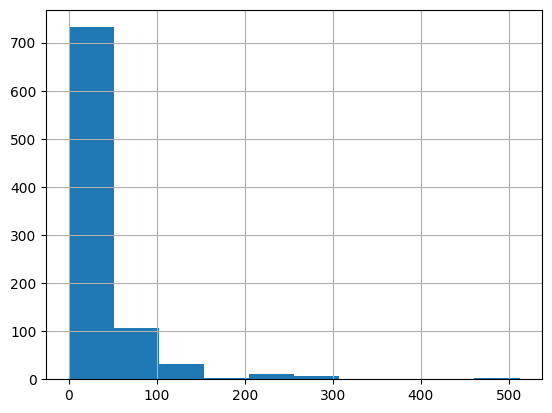

In [11]:
df['Fare'].hist()

In [12]:
# Comom log(0) é infinito, somamos +1 para evitar este problema
df['LogFare'] = np.log(df['Fare']+1)

<Axes: >

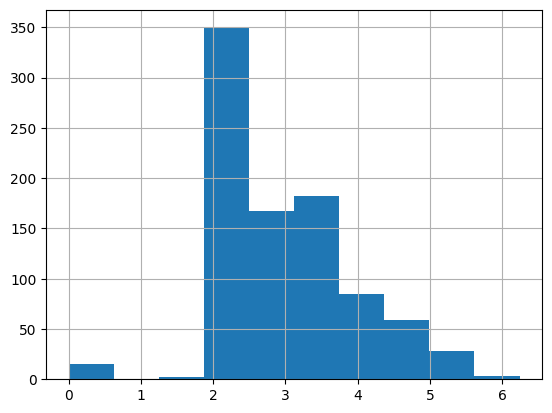

In [13]:
df['LogFare'].hist()

No caso da PClass, apesar de estar representada de forma numérica, é na verdade uma variável categórica, veja:

In [15]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

Obtendo todas as variáveis categóricas

In [16]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Criando dummys para Sex, PClass e Embarked para usar no modelo

In [17]:
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

Criando a variável dependente ou target (*y*)

In [18]:
from torch import tensor
t_dep = tensor(df.Survived)

In [24]:
t_dep[:10]

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

Criando o tensor com as variáveis numéricas + as dummies

In [30]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep


tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [31]:
t_indep.shape

torch.Size([891, 12])

## Calculando manualmente a função custo (*loss*) e as predições
Vamos iniciar a matriz de coeficientes com valores randômicos entre -.5 e .5

In [40]:
torch.manual_seed(42)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs


tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,  0.4408, -0.3668,  0.4346,  0.0936])

Para calcular as predições, iremos multiplicar cada linha pelo coeficiente de cada coluna e somá-los.

É importante observar que não precisamos ter uma coluna com 1s para fazer a vez do intercepto (*ou bias*), pois quando criamos as dummies, não removemos a categoria de referência, neste caso, por exemplo, temos uma dummy para sex_male e outra para sex_female.

In [43]:
t_indep*coeffs

tensor([[ 8.4099,  0.4150, -0.0000,  0.9692, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [14.5262,  0.4150, -0.0000,  1.9661, -0.0000,  0.1009, -0.2434,  0.0000,  0.0000, -0.3668,  0.0000,  0.0000],
        [ 9.9390,  0.0000, -0.0000,  1.0054, -0.0000,  0.1009, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [13.3794,  0.4150, -0.0000,  1.8330, -0.0000,  0.1009, -0.2434,  0.0000,  0.0000, -0.0000,  0.0000,  0.0936],
        [13.3794,  0.0000, -0.0000,  1.0117, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 9.1745,  0.0000, -0.0000,  1.0320, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.4346,  0.0000],
        [20.6425,  0.0000, -0.0000,  1.8224, -0.1096,  0.0000, -0.2434,  0.0000,  0.0000, -0.0000,  0.0000,  0.0936],
        ...,
        [ 9.5567,  0.0000, -0.0000,  0.9580, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [14.9085,  0.0000, -0.5857,  1.5641

Se observarmos bem, os valores obtidos na primeira colunas, que correponde a variável *Age*, são bem maiores que os demais, e portanto irão "dominar" os resultados. 
Neste caso devemos padronizar de forma que todas as colunas fiquem com valores entre 0 e 1. Pode fazer uma z score ou neste caso, iremos pegar o maior valor de cada coluna e dividir seus valores por ele. 

In [48]:
vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals

Veja que *t_indep* é uma matriz (891 linhas com 12 colunas), porém *vals* é apenas um vetor de 12 valores. Então, como é possível dividir uma matriz por um vetor?
Isto acontece que o torch ou numpy aplicam chamada de **[broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html)**.

Em geral, dois tensores são "broadcastable" se estas duas regras acontecem:

* Cada tensor tem ao menos uma dimensão
* Ao iterar através dos tamanhos de cada dimensão, começando pela dimensão da direita, os tamanhos devem ser iguais, ou um deles igual a 1 ou algum deles não existe.

Por exemplo:

* x=torch.empty(5,3,4,1)
* y=torch.empty(  3,1,1)

- x e y são broadcastable.
- 1a dimensão da direita: ambas são = 1
- 2a dimensão da direita: y tem tamanho = 1
- 3a dimensão da direita: tamanha de x = tamanho de y
- 4a dimensão da direita: dimensão de y não existe

Em nosso exemplo, temos:
t_indep =   (891, 12)
vals =      (     12)

1a dimensão da direita: tamanha de t_indep = tamanho de vals
2a dimensão da direita: dimensão de y não existe

Portanto esta operação é *broadcastable*. Neste caso, o calculo resultante é feito da seguinte maneira:

* Se o número de dimensões de x e y não são iguais, adiciona 1 até igualar o tamanho.
* Então, para cada dimensão, o tamanho resultante é o valor máximo entre x e y na dimensão.

Em nosso caso, ficamos com:

t_indep.size() =   (891, 12)
vals.size() =      (  1, 12)

(t_indep/vals).size() = (891, 12)


In [55]:
(t_indep/vals).size()

torch.Size([891, 12])

In [49]:
t_indep*coeffs

tensor([[ 0.1051,  0.0519, -0.0000,  0.1553, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 0.1816,  0.0519, -0.0000,  0.3150, -0.0000,  0.1009, -0.2434,  0.0000,  0.0000, -0.3668,  0.0000,  0.0000],
        [ 0.1242,  0.0000, -0.0000,  0.1611, -0.0000,  0.1009, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 0.1672,  0.0519, -0.0000,  0.2937, -0.0000,  0.1009, -0.2434,  0.0000,  0.0000, -0.0000,  0.0000,  0.0936],
        [ 0.1672,  0.0000, -0.0000,  0.1621, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 0.1147,  0.0000, -0.0000,  0.1654, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.4346,  0.0000],
        [ 0.2580,  0.0000, -0.0000,  0.2920, -0.1096,  0.0000, -0.2434,  0.0000,  0.0000, -0.0000,  0.0000,  0.0936],
        ...,
        [ 0.1195,  0.0000, -0.0000,  0.1535, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 0.1864,  0.0000, -0.0976,  0.2506

Agora pdoemos fazer as predições multiplicando a matriz das variáveis dependentes padronizadas pelos coeficientes e somá-los

In [64]:
# Usando axis=1, pois queremos somar o total das colunas e não das linhas
preds = (t_indep*coeffs).sum(axis=1)

In [65]:
preds.size()

torch.Size([891])

In [66]:
# Pegando os valores das primeiras predições:
preds[:10]

tensor([0.7371, 0.0391, 0.9206, 0.4639, 0.7542, 1.0459, 0.2906, 0.7982, 0.9089, 0.3994])

É claro que estas predições não são as melhores, pois inicializamos os valores dos coeficientes de foram aleatória.
Agora devemos criar uma função de custo ou perda (*loss*), que irá nos informar o quão distante estamos dos valores "corretos". 
Depois iremos utilizar esta função em nossa descida do gradiente (*gradient descent*) para minimizarmos o resultado desta funão de perda.

In [67]:
#Utilizando o Absolute Mean Error
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.6056)

Agora que sabemos como clacular as predições e a perda, vamos criar duas funções para facilitar os passos seguintes:

In [69]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Fazendo um passo de descida do gradiente

Aqui, iremos fazer manualmente um passo (*epoch*) da descida do gradiente. Para isso devemos calcular os gradientes de cada operação, porém como isso é bastante penoso, iremos deixar o pytorch calcular para nós. Para isto devemos chamar a função requires_grad_() em nossa matriz de coeficientes:

In [71]:
coeffs.requires_grad_()

tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,  0.4408, -0.3668,  0.4346,  0.0936], requires_grad=True)

Agora podemos calcular nossa função de perda que o pytorch ser capaz de calcular os gradientes.

In [72]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.6056, grad_fn=<MeanBackward0>)

Veja que o valor da loss não se alterou, porém temos agora uma grad_fun listada na saída. Para fazer o pytorch calcular os gradientes, devemos chamar a função backward()

In [116]:
loss.backward()

Para listar os gradientes calculados, fazemos:

In [74]:
coeffs.grad

tensor([ 0.0883,  0.0272,  0.0056,  0.0608,  0.3423, -0.0853, -0.1324,  0.0202,  0.3692, -0.0786,  0.0842,  0.2514])

Se chamarmos novamente, note que os gradientes são *somados* aos valores anteriores

In [77]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([ 0.1765,  0.0544,  0.0112,  0.1217,  0.6846, -0.1706, -0.2649,  0.0404,  0.7385, -0.1571,  0.1684,  0.5028])

Por isso, devemos sempre zerar (grad.zero())os gradientes após fazermos um passo da descida do gradiente. Portanto, pára fazer um passo completo temos:

In [78]:
# Aqui iremos subtratir 0.1 dos valores dos gradientes (este valor é a taxa de aprendizado ou learning rate)
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5009)


## Treinando o modelo

Antes de treinar o modelo, devemos fazer o split das observações de treino e validação. 

In [80]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

Vamos criar funções para fazer as três coisas que fizemos anteriormente (atualizar coeffs, fazer um passo da descida do gradiente e inicializar os coeficientes randomicamente)

In [82]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [87]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss: .3f}", end="; ")

In [96]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

Agora podemos usar nossas funções em uma função para treinar o modelo

In [94]:
def train_model(epochs=30, lr=0.01): 
    torch.manual_seed(42)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

Vamos treinar o modelo e verificar se a função de perda se reduz conforme os passos do gradiente acontecem. Vamos rodar apenas 18 passos:

In [97]:
coeffs = train_model(18, lr=0.2)

 0.603;  0.533;  0.473;  0.426;  0.385;  0.364;  0.351;  0.333;  0.323;  0.319;  0.304;  0.310;  0.294;  0.299;  0.290;  0.298;  0.286;  0.298; 

Vamos ver os coeficientes em cada coluna:

In [98]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(0.3236),
 'SibSp': tensor(0.3410),
 'Parch': tensor(-0.1211),
 'LogFare': tensor(0.5121),
 'Sex_male': tensor(-0.3934),
 'Sex_female': tensor(0.4033),
 'Pclass_1': tensor(0.1240),
 'Pclass_2': tensor(0.2347),
 'Pclass_3': tensor(0.1507),
 'Embarked_C': tensor(-0.0218),
 'Embarked_Q': tensor(0.2214),
 'Embarked_S': tensor(-0.0197)}

## Medindo a acurácia

Ao invés de medirmos o modelo usando a média do erro absoluto (que é o que nossa função de perda está fazendo), vamos gerar uma nova métrica chama acurácia, ou seja, a proporção de sobreviventes versus não sobreviventes calculado pelo modelo, versus os valores reais. Vamos assumir que acima de 0.5 em nossa predição, consideramos que sobreviveu, e menos ele não sobreviveu:

In [99]:
preds = calc_preds(coeffs, val_indep)

In [100]:
preds

tensor([     1.1692,      0.2537,      0.0055,      0.2481,      0.1392,      0.2554,      0.7472,      0.9481,      0.2318,      0.9103,
             0.0466,      0.0838,     -0.0190,      1.0517,      0.0404,      0.1650,      0.2459,      0.9697,      0.2498,      0.8460,
             0.0140,      0.2095,      1.0728,      1.1585,     -0.0104,      0.3830,      0.7656,      0.2338,     -0.0075,      1.0505,
             0.8673,      1.0892,     -0.0062,      0.0417,      1.1934,      0.9576,      0.1928,      0.9516,      0.0154,      0.8576,
             0.0988,      0.0154,      0.1993,      0.9917,     -0.0008,      0.9033,      0.1752,      0.1291,      0.2459,      0.7964,
             0.5854,      0.2642,      0.1895,      0.0098,      0.1271,      0.1514,      0.2538,      0.1561,      0.0033,      0.0858,
             0.1058,      0.0201,      0.3162,      0.0021,      1.1093,      0.1334,      0.1352,      0.1599,      0.3930,      1.0197,
             0.0221,      0.8177, 

In [102]:
results = val_dep.bool() == (preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

Vamos ver nossa acurácia média:

In [103]:
results.float().mean()

tensor(0.7865)

Vamos criar uma função para calcular a acurácia para outros modelos posteriores. Observe que a acurácia é calculada em relação às observações presentes na amostra de *validação* e não de treino.

In [109]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

Veja que nossas previsões possuem valores negativos e/ou maiores que 1. Neste caso, iremos aplicar uma função (sigmoid) para "achatar" os valores entre 0 e 1:

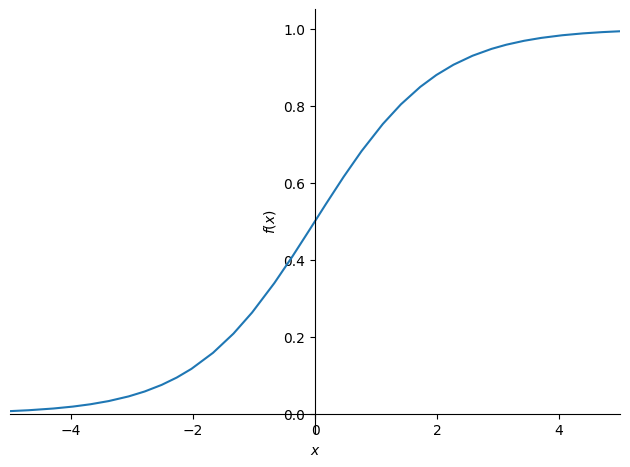

In [111]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

O pytorch já tem esta funçao em sua bibliioteca, portanto iremos utilizá-la em nossa versão da função calc_preds:

In [112]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

Vamos treinar o modelo usando a nova função

In [114]:
#Treinando com 30 épocas e learning rate de 100
coeffs = train_model(lr=100)

 0.546;  0.311;  0.211;  0.201;  0.199;  0.198;  0.197;  0.197;  0.197;  0.196;  0.196;  0.196;  0.196;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194; 

Veja que a acurácia do modelo melhorou:

In [115]:
acc(coeffs)

tensor(0.8258)

## Usando Produto da Matrix
Podemos fazer as coisas ainda mais simples. Veja a seguinte parte do código:

(val_indep*coeffs).sum(axis=1)

Multiplicar elementos e depois somar o total de cada limha é idÇentica à fazer a multiplicação escalar (*dot product*) de duas matrizes, além de ser bem mais rápido.

val_indep@coeffs

Então vamos atualizar nossa calc_preds assim:


In [119]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

## Rede Neural

Antes de criarmos nossa rede neural à partir do modelo linear, devemos fazewr os seguintes ajustes:

1- Transformar nossa matriz de coeficientes em um vetor de coluna, ou seja, uma matriz de 12x1

2- Transformar nossa variável dependente em um vetor de coluna

In [142]:
# Passo 1:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

# Passo 2:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None] 

Vamos testar o treino para confirmar que está tudo ok:

In [149]:
coeffs = train_model(lr=100)

 0.516;  0.322;  0.286;  0.203;  0.200;  0.198;  0.197;  0.197;  0.196;  0.196;  0.196;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194; 

In [150]:
acc(coeffs)

tensor(0.8258)

Agora que preparamos nossa coluna da variável preditora e também das dependentes, devemos criar os coeficientes para cada camada de nossa rede.
Nosso primeiro conjunto de coeficientes usará o n_coeff da camada de entrada e irá criar n_hidden de saída.
Portanto devemos ter uma matrix de n_coeff X n_hidden. Depois iremos dividir por n_hidden, para que quando somarmos na próxima camada, teremos números de magnitude similar aos que começamos.
Depois, em nossa segunda camanda, teremos n_hidden na entrada e iremos criar uma única saída, portanto precisaremos de uma matriz de n_hidden X 1. Esta segunda camada deverá ter também um term constante adicionado.


In [177]:
# Selecionamos 20 arbitrariamente na camada escondida como padrão
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [179]:
l1,l2,const = init_coeffs()
const

tensor(0.6301, requires_grad=True)

In [ ]:
Agora que temos nossos coeficientes, podemos criar nossa rede neural.
Os passos principais são a multiplicação dos termos independentes (indeps@l1) e do resultado do layer1 pelo layer2 (res@12).
Iremos passar o resultado do primeiro layer por uma função RELU que zera os valores negativos e não altera os valores positivos. e por uma sigmoid depois do layer2.

In [180]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1, l2, const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Já que agora temos mais que um conjunto de coeficientes, precisamos adicionar um loop para cada um:

In [161]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Agora vamos treinar o modelo e ver a acurácia:

In [181]:
coeffs = train_model(lr=1.4)

 0.550;  0.543;  0.537;  0.529;  0.519;  0.506;  0.491;  0.472;  0.448;  0.419;  0.388;  0.358;  0.334;  0.316;  0.300;  0.287;  0.275;  0.265;  0.257;  0.251;  0.246;  0.241;  0.238;  0.235;  0.232;  0.230;  0.228;  0.226;  0.225;  0.223; 

In [182]:
acc(coeffs)

tensor(0.7921)

Devido ao tamanho das amostras de treino e validação, houve uma piora nos resultados. Mas ao menos sabemos como a rede neural funciona!

## Deep learning

Usando o mesmo processo podemos criar quantas camadas com quantos neuronios quisermos, mas antes precisamos criar coeficientes adicionais para cada camada:

In [183]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [184]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [185]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [186]:
coeffs = train_model(lr=4)

 0.548;  0.489;  0.475;  0.462;  0.450;  0.440;  0.432;  0.426;  0.420;  0.416;  0.412;  0.409;  0.406;  0.404;  0.402;  0.400;  0.399;  0.397;  0.396;  0.395;  0.394;  0.393;  0.393;  0.392;  0.391;  0.391;  0.390;  0.390;  0.389;  0.389; 

In [187]:
acc(coeffs)

tensor(0.5955)